In [1]:
# This script will clip the Cropland Data Layers (CDL) to a each irrigation district
# in the given watershed.

# Author: Bridget Bittmann
# Date created: 09/02/2021
# Date modified: 09/03/2021

In [2]:
# Import necessary packages

!pip install geopandas #install geopandas, will allow import of .shp files
import geopandas as gpd 
import numpy as np #general array computations
import matplotlib.pyplot as plt #to plot data, works with rasterio
!pip install rasterio
import rasterio as rso #to import Geotiff files
from PIL import Image #to work with Geotiff files
!pip install xarray 
import xarray as xr #for stacking arrays of Geotiffs to reduce computation time
import scipy as sc
import io
import netCDF4 #to work with xarray and geopandas
import os
!pip install rtree
import rtree #need to clip .shp files with geopands
!pip install pygeos
import pygeos
!pip install shapely
import shapely #validate geometry of irrigation districts for self-intersections
import fiona #dependency for geopandas
import pyproj #dependency for geopandas
import pandas as pd #dependency for geopandas
import geopy #dependency for geopandas
!pip install rioxarray #to clip rasters to a .shp file
import rioxarray as rxr

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# Connect to server

from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
# Connect to server continued

%cd gdrive/MyDrive/spatial_colab/datasets/
%ls

/content/gdrive/MyDrive/spatial_colab/datasets
CDL_subsets/  irrigation_companies/  irrig_lbrb/  LBRB_shp/


In [41]:
## Import files from folders

lbrb_bounds = gpd.read_file('LBRB_shp/LBRB_file.shp')
irig_comp = gpd.read_file('irrigation_companies/irrigation_companies.shp')

# open all CDL files and put them in one array
dirname = 'CDL_subsets' #this is the folder for the .tif files
cdl = [] #array where the .tif files will be stored
for fname in os.listdir(dirname): #lists the names of the files in the folder of dirname (ie. CDL_subsets)
  im = rxr.open_rasterio(os.path.join(dirname, fname)) #joins the folder name with the name of the tif file to open tif files
  imarray = xr.DataArray(im) #creates a numpy array of the on of the tif files
  cdl.append(imarray) #adds the tif files into the imarray variable like a list

cdl = np.asarray(cdl) #compiles all the arrays into one array

In [44]:
#Determine the shape of the cdl array
cdl.shape #shape: 17, 2655, 2961

(17, 1, 2655, 2961)

In [52]:
## Determine the CRS of the files

print(lbrb_bounds.crs) #EPSG: 4326, Name: WGS84
print(irig_comp.crs) #EPSG: 8826, Name: NAD83

epsg:4326
epsg:8826


In [8]:
## Tranform .shp files to match the geographic coordinate system of the CDL files
#Projection of CDLs: Albers Equal Conical 
#Geographic coordinate system: NAD 1983

#Need to only transform LBRB_bounds to NAD1983, which is in WGS 1984
lbrb_bounds_transform = lbrb_bounds.to_crs(epsg=8826)

In [9]:
# Need to validate geometry due to self-instersections within irrigation districts
irig_comp_valid = irig_comp.buffer(0) #shapely buffer somehow does this????

In [53]:
## Clip the irrigation companies across the state to the watershed of choice
 
irrig_lbrb = gpd.clip(irig_comp_valid, lbrb_bounds_transform)

<Projected CRS: EPSG:8826>
Name: NAD83 / Idaho Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Idaho.
- bounds: (-117.24, 41.99, -111.04, 49.01)
Coordinate Operation:
- name: Idaho Transverse Mercator
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

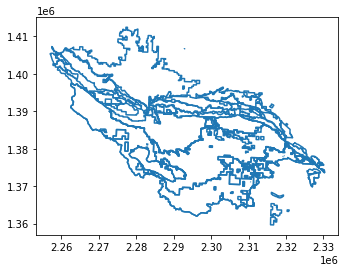

In [11]:
## Plot the irrigation companies to check the clipping
irrig_lbrb.boundary.plot()

#export the new shapefile to folder
irrig_lbrb.to_file('irrig_lbrb')

ESRI:102600
(-1670955.0, 2422935.0, -1582125.0, 2502585.0)
(30.0, -30.0)


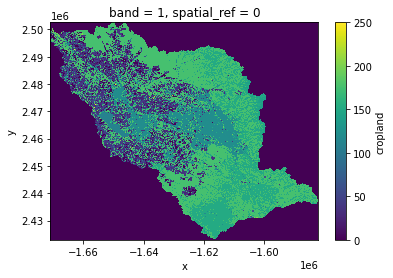

In [58]:
## Clip rasters to the irrigation districts in the watershed

cdl_2010 = rxr.open_rasterio('CDL_subsets/2010.tif')
print(cdl_2010.rio.crs)
cdl_2010.plot()
print(cdl_2010.rio.bounds())
print(cdl_2010.rio.resolution())


#cdl data is originally in NAD_1983_California_Teale_Albers_ftUS
#should I reproject the data? other data in EPSG 8826


EPSG:8826


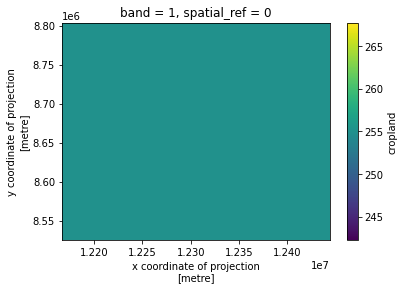

In [59]:
reproject_cdl = cdl_2010.rio.reproject(irrig_lbrb.crs)
print(reproject_cdl.rio.crs)
reproject_cdl.plot()